# Loading dataset

This jupyter was made by: Vinícius Hiroshi Higa.

For more information contact me vini_higa @ GitHub or Vinicius Hiroshi Higa @ LinkedIn

Used dataset: https://www.kaggle.com/datasets/crawford/cat-dataset

In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import PIL
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

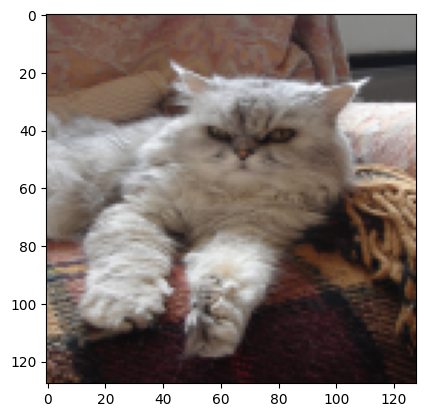

In [2]:
example_img = cv2.imread("./CAT - Dataset/CAT_00/00000001_000.jpg", cv2.IMREAD_COLOR)
example_img = cv2.resize(example_img, (128,128), interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
len(os.listdir("./CAT - Dataset/CAT_00/")) // 2 # We must divide 2, because we have .cat files

1706

# Building filtered dataset

In [4]:
for file_name in os.listdir("./CAT - Dataset/CAT_00/"):
    if not file_name.endswith(".cat"):
        img = cv2.imread("./CAT - Dataset/CAT_00/" + file_name, cv2.IMREAD_COLOR)
        try:
            img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
            cv2.imwrite("./filtered/" + file_name, img)
        except:
            print("Arquivo " + file_name + " falhou!")

Arquivo Thumbs.db falhou!


# Loading training dataset

In [49]:
dataset = keras.utils.image_dataset_from_directory(
    "./filtered/", label_mode=None, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 1706 files belonging to 1 classes.


# Building model

We must remember that...

You can use this formula for calculating the output size of a convolution.
$$ [(W−K+2P)/S]+1 $$

W is the input volume - in this case 128

K is the Kernel size - in this case 4

P is the padding - in this case 1

S is the stride - in this case 2

In [50]:
NUM_COLORS = 3
IMAGE_SIZE = 128

generator = models.Sequential([
    layers.Dense(8 * 8 * 128, input_shape=(IMAGE_SIZE,)),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name='generator_model')

generator.summary()


Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 256)   

In [51]:
discriminator = models.Sequential([
    layers.Conv2D(32, (32, 32), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (16, 16), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
], name="discriminator_model")

discriminator.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 97, 97, 32)        98336     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 33, 33, 64)        524352    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 16384)             0         
                                                                 
 dense_27 (Dense)            (None, 128)       

In [55]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, gen_optimizer, disc_optimizer, loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn
        self.gen_loss_metric = keras.metrics.Mean(name="gen_loss_mean")
        self.disc_loss_metric = keras.metrics.Mean(name="disc_loss_mean")
        
    @property
    def metrics(self):
        return [self.gen_loss_metric, self.disc_loss_metric]
    
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.disc_loss_metric.update_state(d_loss)
        self.gen_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.disc_loss_metric.result(),
            "g_loss": self.gen_loss_metric.result(),
        }

In [56]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=IMAGE_SIZE)
gan.compile(
    keras.optimizers.Adam(learning_rate=0.0001),
    keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=IMAGE_SIZE)], verbose=1
)